In [9]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from skimage import measure


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

# executable
print(sys.executable)

/home/stefan/coding/notebooks/env/bin/python


In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [4]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


In [5]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


# Find contours of surfaces

In [71]:
# get start and end of section in grid scalar vals array
arr_len_0, arr_len_n = geo_model.grid.sections.get_section_args('section')

# CAUTION: if more section present they have to be indexexed accrodingly;
# get shape of section  # 1st and only one here as only one section present.
section_shape = geo_model.grid.sections.resolution[0]
# extract section scalar values from solutions.sections# [series,serie_pos_0:serie_pos_n]
section_scalar_field_values = geo_model.solutions.sections[1][:,arr_len_0:arr_len_n]

# number scalar field blocks
n_scalar_field_blocks = section_scalar_field_values.shape[0]
# creat a dictionary to assemble all scalat field boolen matrices shifts
# extract transition towards current level
contours = {}
for i in range(n_scalar_field_blocks):

    # scalarfield values of scalarfield_block-i
    block = section_scalar_field_values[i, :]
    # ??? level
    level = geo_model.solutions.scalar_field_at_surface_points[i][np.where(
        geo_model.solutions.scalar_field_at_surface_points[i] != 0)]
    # ??? calulcate scalarfeild levels
    levels = np.insert(level, 0, block.max())
    # extract and reshape scalar field values
    scalar_field = block.reshape(section_shape).T
    # loop over levels to extract tops present within current scalar field
    for ii in range(len(levels)):
        
        # get top name
        top_name = geo_model.surfaces.df['surface'][ii]        
        # Find contour
        contour = measure.find_contours(scalar_field, levels[ii])
        # add contour to contoures if there are some
        if len(contour) > 0:         
            
            contours[top_name] = contour[0]

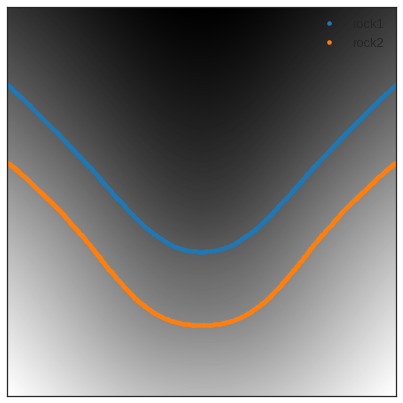

In [74]:
fig, ax = plt.subplots()
ax.imshow(scalar_field, cmap=plt.cm.gray)

for key in contours.keys():
    
    ax.plot(contours[key][:,1], contours[key][:,0], '.', label=key)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()